In [1]:
# magic command for automatic reload of python modules without needing to restart the notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sc
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
tfb=tfp.bijectors
from scipy import io
import time
import matplotlib.pyplot as plt
from sklearn import mixture
import joblib as jbl
import sys
import os
import sklearn
import pandas as pd
import utils as utl
import seaborn as sns
from FlowDists import CopulaFlow, RealNVPFlow
from custom_bijectors import Marginal_transforms, nonParam_Marginals
from sklearn import preprocessing as preproc
from UCI_data_preproc.gas import GAS
from UCI_data_preproc.power import POWER
from UCI_data_preproc.miniboone import MINIBOONE
from UCI_data_preproc.hepmass import HEPMASS

In [17]:
datasets = ['POWER', 'GAS','MINIBOONE', 'HEPMASS']
num_bijectors={'GAS':5, 'POWER':5, 'HEPMASS':10, 'MINIBOONE':10}

for dataset in datasets:

    if dataset == 'GAS':
        # Load UCI  dataset
        data_trn_native=GAS().trn.x
        data_tst_native=GAS().tst.x
    elif dataset == 'POWER':
        # Load UCI  dataset
        data_trn_native=POWER().trn.x
        data_tst_native=POWER().tst.x
    elif dataset == 'HEPMASS':
        # Load UCI  dataset
        data_trn_native=HEPMASS().trn.x
        data_tst_native=HEPMASS().tst.x
    elif dataset == 'MINIBOONE':
        # Load UCI  dataset
        data_trn_native=MINIBOONE().trn.x
        data_tst_native=MINIBOONE().tst.x

    # splitting the data into training, testing and validation sets
    data_trn_native,data_vld_native,_ = utl.splitData(data_trn_native,[0.75,0.25])

    n_samps_trn,n_dims = data_trn_native.shape
    n_samps_vld,_ = data_vld_native.shape
    n_samps_tst,_ = data_tst_native.shape

    print(f'{dataset}: Number of Training samples = {n_samps_trn}, Number of dimensions = {n_dims}')
    print(f'{dataset}: Number of Validation samples = {n_samps_vld}, Number of dimensions = {n_dims}')
    print(f'{dataset}: Number of Testing samples = {n_samps_tst}, Number of dimensions = {n_dims}')
    
    # removing the extreme outliers from the data
    # first getting the bounds (dimension-wise) on the training data
    data_trn_native, bounds = utl.removeOutliers(data_trn_native)
    # then, removing the outliers from the testing and validation data using the same bounds
    data_tst_native, _ = utl.removeOutliers(data_tst_native, bounds)
    data_vld_native, _ = utl.removeOutliers(data_vld_native, bounds)
    
    # Specifying the marginal bijector (from a prelearned distribution)
    marg_attributes=jbl.load(f'saved_models/marginal_params_{dataset}')
    logits,mus,log_sigs=marg_attributes['marg_gmm_params']
    lambdas,min_val=marg_attributes['pw_trans_params']

    # marginal gmms in transformed sapce as the base distribution
    base_dist = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logits),
                               components_distribution=tfd.Normal(loc=mus, scale=tf.exp(log_sigs)))
    # bijector for power transforming
    power_trans_bijec= tfb.Chain([tfb.Shift(shift=min_val), 
                                  tfb.Power(power=1/lambdas),
                                  tfb.Shift(shift=1.),
                                  tfb.Scale(scale=lambdas)])
    # marginal distribution in the native space
    marginals_native=tfd.TransformedDistribution(distribution=base_dist,bijector=power_trans_bijec)
    # sorted samples in the native space
    marginals_samps = marg_attributes['sorted_native_samps']
    
    # Instantiating Copula Flow 
    cpf_obj=CopulaFlow(n_dims,  
                       (marginals_native, marginals_samps), 
                       num_bijectors=num_bijectors[dataset],
                       hidden_layers_size=[min(64,4*n_dims)]*2)
    # Learning the Copula Flow
    nll_cpf=cpf_obj.fit_dist(data_trn_native,
                data_valid=data_vld_native,
                optimizer = tf.optimizers.Adam(learning_rate=1E-4), 
                reg_param=0.1,
                max_iters = 100000, 
                batch_size = 100, 
                print_interval=500,
                checkpoint_interval=500,
                checkpoint_prefix=f'saved_models/{dataset}/CPF_LR_1Em4/base_flow')
    jbl.dump(nll_cpf,f'saved_models/{dataset}/training_errors_CPF_1Em4')
    
#     # Intantiation Real-NVP Flow 
#     nvpf_obj = RealNVPFlow(n_dims,
#                            num_bijectors=num_bijectors[dataset],
#                            hidden_layers_size=[min(64,4*n_dims)]*2)
#     # Learning Real-NVP flow
#     nll_nvpf=nvpf_obj.fit_dist(data_trn_native,
#                 data_valid=data_vld_native,
#                 optimizer = tf.optimizers.Adam(learning_rate=1E-3),
#                 max_iters = 100000, 
#                 batch_size = 100, 
#                 print_interval=500,
#                 checkpoint_interval=500,               
#                 checkpoint_prefix=f'saved_models/{dataset}/RNVP2/rnvp_flow')
#     jbl.dump(nll_nvpf,f'saved_models/{dataset}/training_errors_RNVP2')

POWER: Number of Training samples = 1244941, Number of dimensions = 6
POWER: Number of Validation samples = 414976, Number of dimensions = 6
POWER: Number of Testing samples = 204928, Number of dimensions = 6
Removinng 3281 outliers out of total 1244941 datapoints.
Removinng 582 outliers out of total 204928 datapoints.
Removinng 1104 outliers out of total 414976 datapoints.
@ Iter:0,                             Training error: 1.3,                             Validation error: 0.9,                             Time Elapsed: 12.0 s
@ Iter:500,                             Training error: 0.2,                             Validation error: 0.8,                             Time Elapsed: 54.6 s
@ Iter:1000,                             Training error: 0.8,                             Validation error: 0.6,                             Time Elapsed: 97.8 s
@ Iter:1500,                             Training error: 0.5,                             Validation error: 1.1,                             

@ Iter:24000,                             Training error: 0.6,                             Validation error: 0.5,                             Time Elapsed: 1979.0 s
@ Iter:24500,                             Training error: 0.6,                             Validation error: 1.1,                             Time Elapsed: 2015.2 s
@ Iter:25000,                             Training error: 0.4,                             Validation error: -0.0,                             Time Elapsed: 2051.6 s
@ Iter:25500,                             Training error: 0.5,                             Validation error: 0.3,                             Time Elapsed: 2088.7 s
@ Iter:26000,                             Training error: 0.3,                             Validation error: 0.1,                             Time Elapsed: 2125.9 s
@ Iter:26500,                             Training error: 0.5,                             Validation error: 0.4,                             Time Elapsed: 2163.5 s
@ Iter:27

@ Iter:49000,                             Training error: -0.0,                             Validation error: 0.4,                             Time Elapsed: 3821.1 s
@ Iter:49500,                             Training error: -0.0,                             Validation error: 0.3,                             Time Elapsed: 3857.5 s
@ Iter:50000,                             Training error: 0.3,                             Validation error: 1.0,                             Time Elapsed: 3894.0 s
@ Iter:50500,                             Training error: 0.6,                             Validation error: 0.1,                             Time Elapsed: 3931.1 s
@ Iter:51000,                             Training error: 0.7,                             Validation error: 0.3,                             Time Elapsed: 3967.9 s
@ Iter:51500,                             Training error: 0.2,                             Validation error: -0.1,                             Time Elapsed: 4004.3 s
@ Iter:

@ Iter:74000,                             Training error: 0.2,                             Validation error: -0.0,                             Time Elapsed: 5643.1 s
@ Iter:74500,                             Training error: 0.4,                             Validation error: 1.2,                             Time Elapsed: 5679.0 s
@ Iter:75000,                             Training error: 0.1,                             Validation error: 0.1,                             Time Elapsed: 5715.5 s
@ Iter:75500,                             Training error: 0.5,                             Validation error: 0.1,                             Time Elapsed: 5751.9 s
@ Iter:76000,                             Training error: 0.0,                             Validation error: -0.3,                             Time Elapsed: 5789.2 s
@ Iter:76500,                             Training error: 0.0,                             Validation error: 0.1,                             Time Elapsed: 5826.0 s
@ Iter:7

@ Iter:99000,                             Training error: 0.2,                             Validation error: 0.7,                             Time Elapsed: 7464.4 s
@ Iter:99500,                             Training error: 0.2,                             Validation error: 0.0,                             Time Elapsed: 7500.4 s
GAS: Number of Training samples = 639134, Number of dimensions = 8
GAS: Number of Validation samples = 213040, Number of dimensions = 8
GAS: Number of Testing samples = 105206, Number of dimensions = 8
Removinng 1425 outliers out of total 639134 datapoints.
Removinng 250 outliers out of total 105206 datapoints.
Removinng 503 outliers out of total 213040 datapoints.
@ Iter:0,                             Training error: 7.6,                             Validation error: 7.2,                             Time Elapsed: 9.5 s
@ Iter:500,                             Training error: 5.4,                             Validation error: 6.1,                             Time

@ Iter:23000,                             Training error: -2.1,                             Validation error: -2.6,                             Time Elapsed: 1111.0 s
@ Iter:23500,                             Training error: -2.4,                             Validation error: -2.3,                             Time Elapsed: 1134.9 s
@ Iter:24000,                             Training error: -3.2,                             Validation error: -2.6,                             Time Elapsed: 1159.1 s
@ Iter:24500,                             Training error: -2.4,                             Validation error: -2.1,                             Time Elapsed: 1183.2 s
@ Iter:25000,                             Training error: -2.5,                             Validation error: -2.7,                             Time Elapsed: 1207.1 s
@ Iter:25500,                             Training error: -3.0,                             Validation error: -1.9,                             Time Elapsed: 1231.0 

@ Iter:48000,                             Training error: -3.0,                             Validation error: -3.8,                             Time Elapsed: 2310.6 s
@ Iter:48500,                             Training error: -2.3,                             Validation error: -3.2,                             Time Elapsed: 2334.8 s
@ Iter:49000,                             Training error: -2.7,                             Validation error: -2.3,                             Time Elapsed: 2358.9 s
@ Iter:49500,                             Training error: -3.3,                             Validation error: -3.3,                             Time Elapsed: 2383.1 s
@ Iter:50000,                             Training error: -3.5,                             Validation error: -3.0,                             Time Elapsed: 2407.1 s
@ Iter:50500,                             Training error: -2.6,                             Validation error: -3.4,                             Time Elapsed: 2431.2 

@ Iter:73000,                             Training error: -4.1,                             Validation error: -3.8,                             Time Elapsed: 3513.2 s
@ Iter:73500,                             Training error: -3.1,                             Validation error: -3.1,                             Time Elapsed: 3537.2 s
@ Iter:74000,                             Training error: -4.0,                             Validation error: -3.8,                             Time Elapsed: 3561.3 s
@ Iter:74500,                             Training error: -3.9,                             Validation error: -3.3,                             Time Elapsed: 3585.5 s
@ Iter:75000,                             Training error: -3.4,                             Validation error: -3.7,                             Time Elapsed: 3609.8 s
@ Iter:75500,                             Training error: -3.1,                             Validation error: -4.0,                             Time Elapsed: 3634.0 

@ Iter:98000,                             Training error: -4.4,                             Validation error: -4.6,                             Time Elapsed: 4722.7 s
@ Iter:98500,                             Training error: -3.6,                             Validation error: -3.0,                             Time Elapsed: 4746.9 s
@ Iter:99000,                             Training error: -3.6,                             Validation error: -3.0,                             Time Elapsed: 4771.1 s
@ Iter:99500,                             Training error: -3.6,                             Validation error: -3.3,                             Time Elapsed: 4795.2 s
MINIBOONE: Number of Training samples = 22183, Number of dimensions = 43
MINIBOONE: Number of Validation samples = 7373, Number of dimensions = 43
MINIBOONE: Number of Testing samples = 3648, Number of dimensions = 43
Removinng 290 outliers out of total 22183 datapoints.
Removinng 41 outliers out of total 3648 datapoints.
Removinn

@ Iter:22000,                             Training error: 15.6,                             Validation error: 17.2,                             Time Elapsed: 3341.6 s
@ Iter:22500,                             Training error: 16.3,                             Validation error: 13.2,                             Time Elapsed: 3417.3 s
@ Iter:23000,                             Training error: 15.2,                             Validation error: 16.5,                             Time Elapsed: 3491.7 s
@ Iter:23500,                             Training error: 17.7,                             Validation error: 16.1,                             Time Elapsed: 3566.1 s
@ Iter:24000,                             Training error: 15.7,                             Validation error: 17.1,                             Time Elapsed: 3640.8 s
@ Iter:24500,                             Training error: 14.7,                             Validation error: 14.5,                             Time Elapsed: 3716.0 

@ Iter:47000,                             Training error: 16.0,                             Validation error: 15.2,                             Time Elapsed: 7099.6 s
@ Iter:47500,                             Training error: 12.4,                             Validation error: 13.7,                             Time Elapsed: 7174.3 s
@ Iter:48000,                             Training error: 13.1,                             Validation error: 13.5,                             Time Elapsed: 7249.5 s
@ Iter:48500,                             Training error: 13.5,                             Validation error: 14.9,                             Time Elapsed: 7324.7 s
@ Iter:49000,                             Training error: 15.9,                             Validation error: 15.4,                             Time Elapsed: 7400.3 s
@ Iter:49500,                             Training error: 13.5,                             Validation error: 13.5,                             Time Elapsed: 7476.8 

@ Iter:71500,                             Training error: 11.4,                             Validation error: 12.6,                             Time Elapsed: 10936.5 s
@ Iter:72000,                             Training error: 14.2,                             Validation error: 14.3,                             Time Elapsed: 11017.8 s
@ Iter:72500,                             Training error: 13.4,                             Validation error: 14.1,                             Time Elapsed: 11096.4 s
@ Iter:73000,                             Training error: 14.2,                             Validation error: 15.4,                             Time Elapsed: 11182.7 s
@ Iter:73500,                             Training error: 11.7,                             Validation error: 12.3,                             Time Elapsed: 11260.2 s
@ Iter:74000,                             Training error: 12.8,                             Validation error: 11.2,                             Time Elapsed: 11

@ Iter:96000,                             Training error: 14.8,                             Validation error: 16.6,                             Time Elapsed: 14786.8 s
@ Iter:96500,                             Training error: 11.6,                             Validation error: 15.7,                             Time Elapsed: 14863.6 s
@ Iter:97000,                             Training error: 11.7,                             Validation error: 12.8,                             Time Elapsed: 14941.6 s
@ Iter:97500,                             Training error: 13.1,                             Validation error: 15.1,                             Time Elapsed: 15018.7 s
@ Iter:98000,                             Training error: 12.9,                             Validation error: 14.0,                             Time Elapsed: 15095.8 s
@ Iter:98500,                             Training error: 12.9,                             Validation error: 14.3,                             Time Elapsed: 15

C:\Users\tewar\OneDrive\Documents\work\FlowCopula_v2\UCI_data_preproc\hepmass.py:35: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data_train = pd.read_csv(filepath_or_buffer=join(path, "1000_train.csv"), index_col=False)
C:\Users\tewar\OneDrive\Documents\work\FlowCopula_v2\UCI_data_preproc\hepmass.py:35: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data_train = pd.read_csv(filepath_or_buffer=join(path, "1000_train.csv"), index_col=False)


HEPMASS: Number of Training samples = 236352, Number of dimensions = 21
HEPMASS: Number of Validation samples = 78771, Number of dimensions = 21
HEPMASS: Number of Testing samples = 174987, Number of dimensions = 21
Removinng 25 outliers out of total 236352 datapoints.
Removinng 13 outliers out of total 174987 datapoints.
Removinng 6 outliers out of total 78771 datapoints.
@ Iter:0,                             Training error: 26.0,                             Validation error: 26.0,                             Time Elapsed: 16.7 s
@ Iter:500,                             Training error: 25.6,                             Validation error: 26.3,                             Time Elapsed: 111.4 s
@ Iter:1000,                             Training error: 25.2,                             Validation error: 25.3,                             Time Elapsed: 200.1 s
@ Iter:1500,                             Training error: 25.4,                             Validation error: 25.8,                    

@ Iter:24000,                             Training error: 23.2,                             Validation error: 23.2,                             Time Elapsed: 4317.4 s
@ Iter:24500,                             Training error: 23.0,                             Validation error: 23.6,                             Time Elapsed: 4405.7 s
@ Iter:25000,                             Training error: 22.9,                             Validation error: 22.9,                             Time Elapsed: 4493.8 s
@ Iter:25500,                             Training error: 23.1,                             Validation error: 22.7,                             Time Elapsed: 4583.0 s
@ Iter:26000,                             Training error: 23.2,                             Validation error: 23.2,                             Time Elapsed: 4671.5 s
@ Iter:26500,                             Training error: 22.1,                             Validation error: 22.9,                             Time Elapsed: 4760.0 

@ Iter:49000,                             Training error: 22.0,                             Validation error: 22.0,                             Time Elapsed: 8762.1 s
@ Iter:49500,                             Training error: 22.7,                             Validation error: 22.1,                             Time Elapsed: 8850.8 s
@ Iter:50000,                             Training error: 22.5,                             Validation error: 21.7,                             Time Elapsed: 8939.1 s
@ Iter:50500,                             Training error: 22.5,                             Validation error: 22.1,                             Time Elapsed: 9027.7 s
@ Iter:51000,                             Training error: 22.6,                             Validation error: 22.3,                             Time Elapsed: 9116.4 s
@ Iter:51500,                             Training error: 22.2,                             Validation error: 22.4,                             Time Elapsed: 9205.1 

@ Iter:73500,                             Training error: 21.5,                             Validation error: 21.9,                             Time Elapsed: 13132.2 s
@ Iter:74000,                             Training error: 22.3,                             Validation error: 22.0,                             Time Elapsed: 13221.1 s
@ Iter:74500,                             Training error: 21.3,                             Validation error: 22.0,                             Time Elapsed: 13309.5 s
@ Iter:75000,                             Training error: 21.7,                             Validation error: 21.5,                             Time Elapsed: 13397.8 s
@ Iter:75500,                             Training error: 21.8,                             Validation error: 21.7,                             Time Elapsed: 13485.8 s
@ Iter:76000,                             Training error: 20.9,                             Validation error: 21.9,                             Time Elapsed: 13

@ Iter:98000,                             Training error: 21.5,                             Validation error: 21.6,                             Time Elapsed: 17457.4 s
@ Iter:98500,                             Training error: 22.2,                             Validation error: 21.6,                             Time Elapsed: 17544.9 s
@ Iter:99000,                             Training error: 21.0,                             Validation error: 20.8,                             Time Elapsed: 17631.9 s
@ Iter:99500,                             Training error: 21.3,                             Validation error: 21.4,                             Time Elapsed: 17726.8 s


In [32]:
nll_cpf1=jbl.load('saved_models/GAS/training_errors_CPF2')
nll_cpf2=jbl.load('saved_models/GAS/training_errors_CPF')

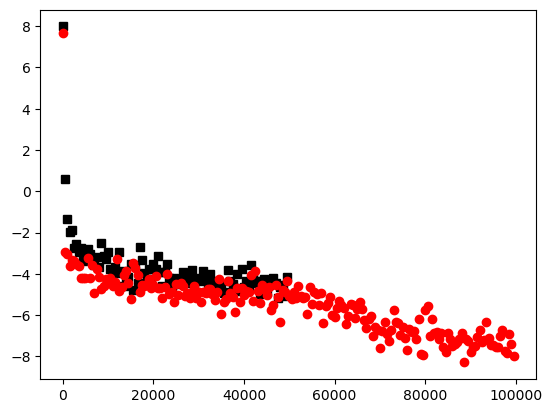

In [31]:
plt.plot(nll_cpf1[1],'ks')
plt.plot(nll_cpf2[1],'ro')
# plt.xlim([15000,20000])
# plt.ylim([-7, 20])